In [8]:
suppressMessages({
    library(Seurat)
    library(SeuratWrappers)
    library(tidyverse)
    library(harmony)
    library(ggrepel)
    library(ggrastr)
    library(magrittr)
    # GO enrich use packages
    library(DOSE)
    library(clusterProfiler)
    library(org.Hs.eg.db)
    library(ggplot2)
    library(dplyr)
    library(topGO)
    library(GSEABase)
    library(stringr)
    library(RColorBrewer)
    ## RNA velocity
    library(velocyto.R)
    library(singleseqgset)
    library(ComplexHeatmap)
    library(ggsci)
})

# load and save vars and functions

In [15]:
logFC.change <- function(cluster.ids,expr.mat) {
    if (is.factor(cluster.ids)==F) {
      cluster.ids <- as.factor(cluster.ids)
    }

    if (!class(expr.mat)=="dgCMatrix") {
        expr.mat <- Matrix(expr.mat,sparse=TRUE)
    }

    cluster.cells <- vector(mode="list",length=length(levels(cluster.ids)))
    names(cluster.cells) <- levels(cluster.ids)

    for (i in names(cluster.cells)) {
        cluster.cells[[i]] <- colnames(expr.mat)[which(cluster.ids==i)]
    }

    log.fc.cluster <- vector(mode="list",length=length(cluster.cells))
    names(log.fc.cluster) <- names(cluster.cells)

    sym_diff <- function(a,b) { unique(setdiff(a,b),setdiff(b,a)) }

    for (i in 1:length(cluster.cells)) {

        other.clusters <- sym_diff(names(cluster.cells),names(cluster.cells)[i])

       mean.cluster.exp <- log(rowMeans(expm1(expr.mat[,cluster.cells[[i]]])) + 1)
       mean.exp.other <- log(rowMeans(expm1(expr.mat[,c(unlist(cluster.cells[other.clusters]))])) + 1)


        log.fc.cluster[[i]] <- mean.cluster.exp-mean.exp.other

    }

    return(list("cluster.cells"=cluster.cells,"log.fc.cluster"=log.fc.cluster))

}



wmw_gsea.change <- function(expr.mat,cluster.cells,log.fc.cluster,gene.sets)

{

# if (!class(expr.mat)=="matrix") {
# 	expr.mat <- as.matrix(expr.mat)
# }

results <- vector(mode="list",length=length(cluster.cells))

for (z in 1:length(cluster.cells)) {

gene.statistics <- log.fc.cluster[[z]]

data <- as.matrix(t(expr.mat[,cluster.cells[[z]]]))
n <- nrow(data)
p <- ncol(data)
gene.set.indexes = gene.sets

num.gene.sets <- length(gene.set.indexes)
p.values <- matrix(1,nrow=num.gene.sets)
rownames(p.values) <- names(gene.set.indexes)
gene.set.statistics <- matrix(0,nrow=num.gene.sets)
rownames(gene.set.statistics) <- names(gene.set.indexes)

for (i in 1:num.gene.sets) {

	x.test <- gene.statistics[!is.na(match(names(gene.statistics),gene.set.indexes[[i]]))]
	y.test <- gene.statistics[is.na(match(gene.statistics,gene.set.indexes[[i]]))]

	if (length(x.test)<5) {
		gene.set.statistics[i] <- 0
		p.values[i] <- 1
	} else {

		data.sub <- as.matrix(data[,names(x.test)])
		data.values <- apply(data.sub,2,sum)
		data.val.pos <- length(which(data.values>0))

		if (data.val.pos<5) {
			gene.set.statistics[i] <- 0
			p.values[i] <- 1
		} else {

			data.val.index <- which(data.values>0)

			wilcox.results <- wilcox.test(x=x.test,y=y.test,alternative="two.sided",exact=F,correct=F)

			cor.mat <- cor(as.matrix(data.sub[,data.val.index]))
			cor.mat <- cor.mat[upper.tri(cor.mat,diag=F)]
			cor.mat <- cor.mat[which(!is.na(cor.mat))]
			mean.cor <- mean(cor.mat)

			m1 <- length(x.test)
			m2 <- length(y.test)

			rank.sum <- wilcox.results$statistic
			var.rank.sum <- ((m1*m2)/(2*pi))*(asin(1) + (m2 - 1)*asin(.5) + (m1-1)*(m2-1)*asin(mean.cor/2) +(m1-1)*asin((mean.cor+1)/2))
			z.stat = (rank.sum - (m1*m2)/2)/sqrt(var.rank.sum)
			gene.set.statistics[i] = z.stat
			lower.p = pnorm(z.stat,lower.tail=T)
			upper.p = pnorm(z.stat,lower.tail=F)
			p.values[i] = 2*min(lower.p,upper.p)
			}
		}
	}

results[[z]]$p.values <- p.values
results[[z]]$statistics <- gene.set.statistics

}

p.val.res <- data.frame(lapply(results,function(x) x[1]))
statistics.res <- data.frame(lapply(results,function(x) x[2]))
colnames(p.val.res) <- colnames(statistics.res) <- names(cluster.cells)

zero.index <- which(apply(statistics.res,1,function(x) all(x==0))==T)
	if (length(zero.index)>0) {
		print(paste("Removed ",length(zero.index)," rows with all z-scores equal to zero.",sep=""))
		statistics.res <- statistics.res[-zero.index,]
		p.val.res <- p.val.res[-zero.index,]
	}


return(list("GSEA_statistics"=statistics.res,"GSEA_p_values"=p.val.res))

}


In [9]:
suppressMessages(
    source("~/project/2020-6-18-IVDD_scRNA/scripts/R_scripts/preferable_scripts/common_use_functions.R")
) 

In [10]:
options(repr.plot.width=14, repr.plot.height=10)

In [2]:
all.seu <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/new_noC03_combn_SeuratObj.Rds")

In [3]:
dim(all.seu)

[1] 33538 73562

In [3]:
unique(Idents(all.seu))

[1] Nucleus Pulposus            B cell                     
 [3] Monocyte/Macrophage         CD24+ progenitor           
 [5] MKI67+ progenitor           Neutrophic                 
 [7] Plasmacytoid dendritic cell Annulus Fibrosus           
 [9] CD8 T                       Endothelial Progenitor     
[11] Erythrocyte                 Neural Progenitor          
[13] MCAM+ progenitor            Mast                       
14 Levels: Nucleus Pulposus B cell Monocyte/Macrophage ... Mast

In [12]:
A.plot <- 
  plot.seu.raster(all.seu)+ NoAxes() +
  scale_color_npg()
A.plot <- LabelClusters(A.plot, id = "ident", size = 5, repel = T, color="black")

Warning message:
“This manual palette can handle a maximum of 10 values. You have supplied 14.”


Warning message:
“This manual palette can handle a maximum of 10 values. You have supplied 14.”
Warning message:
“Removed 806 rows containing missing values (geom_point).”


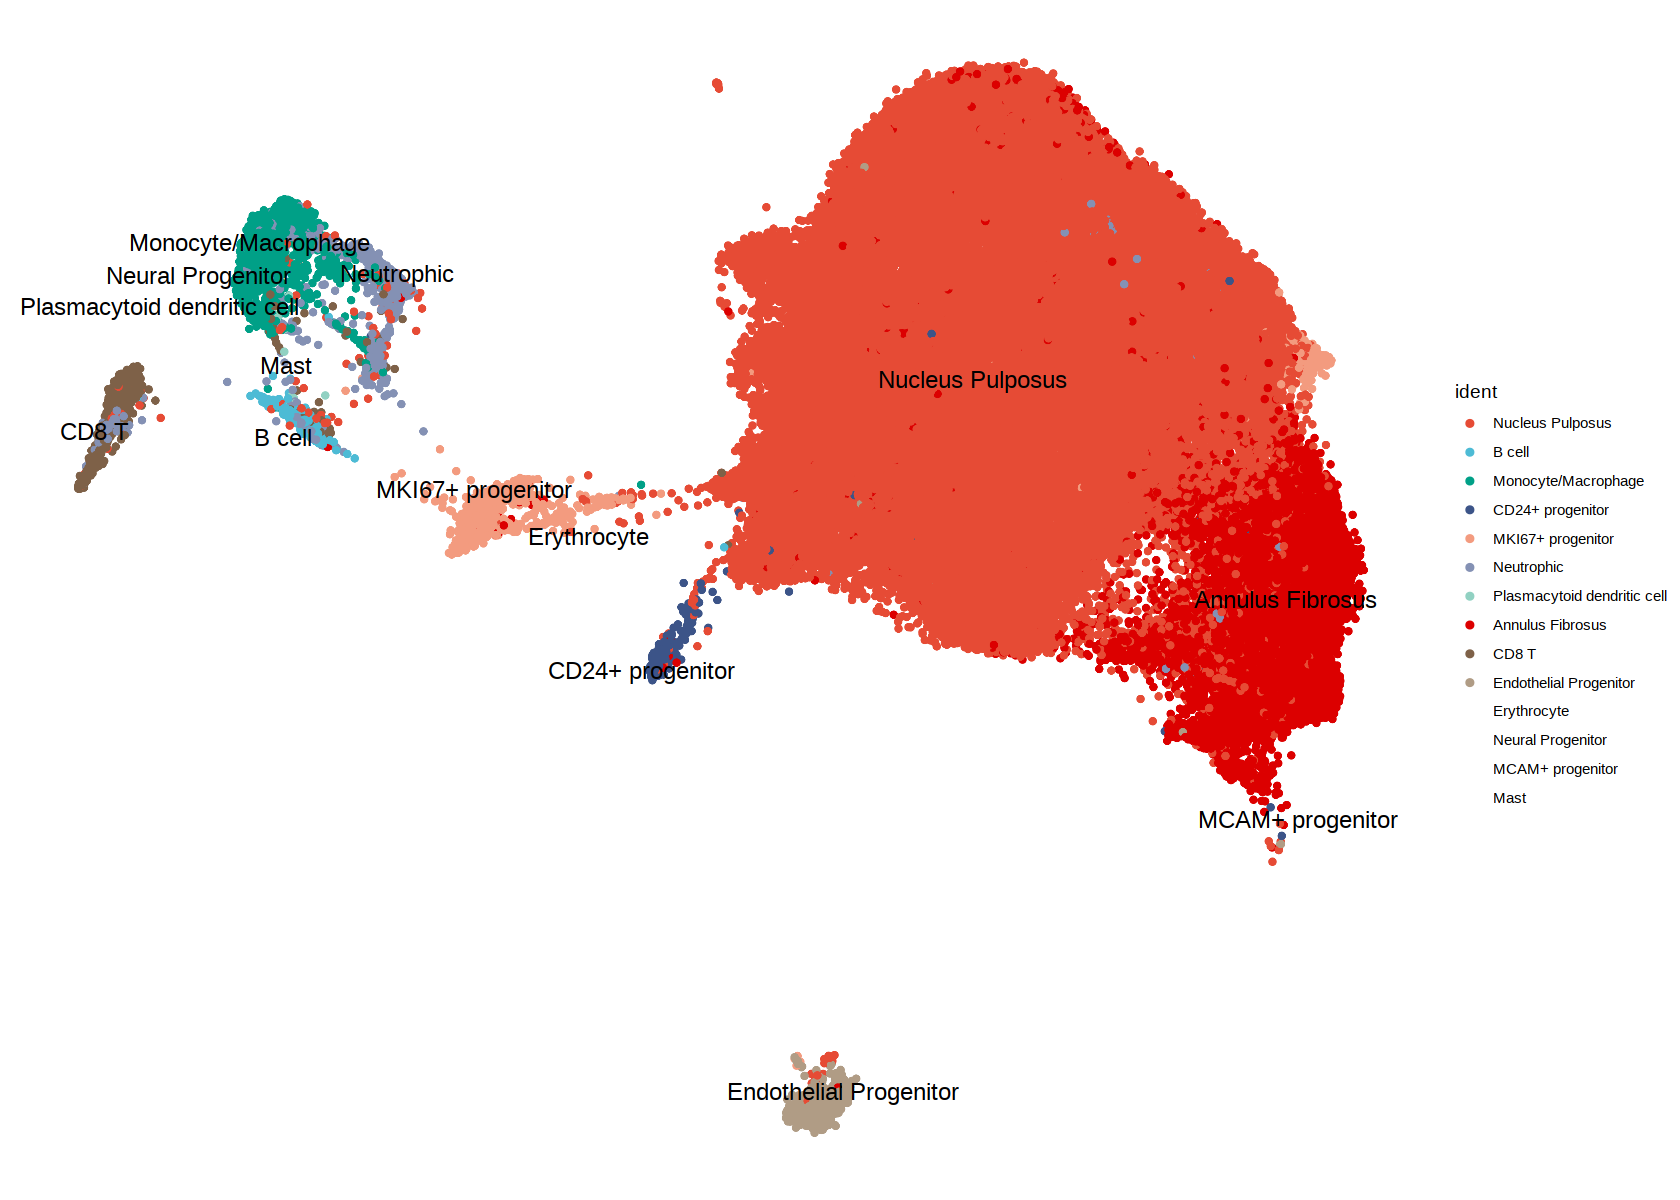

In [13]:
A.plot

In [4]:
all.markers <- FindAllMarkers(all.seu, only.pos = T, min.pct = 0.2, test.use = "MAST")

Calculating cluster Nucleus Pulposus


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster B cell


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster Monocyte/Macrophage


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster CD24+ progenitor


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster MKI67+ progenitor


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster Neutrophic


In [5]:
nrow(all.markers)

[1] 12784

In [6]:
colnames(all.markers)

[1] "p_val"      "avg_log2FC" "pct.1"      "pct.2"      "p_val_adj" 
[6] "cluster"    "gene"

In [7]:
all.markers <- all.markers %>% dplyr::filter(., p_val_adj < 0.05)

In [10]:
write.csv(all.markers, file = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/all_celltype_markers.csv",
         row.names=F, quote=F)

In [9]:
head(all.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SNORC,0,2.534024,0.887,0.355,0,Nucleus Pulposus,SNORC
C2orf40,0,2.372535,0.955,0.696,0,Nucleus Pulposus,C2orf40
CNMD,0,2.120530,0.823,0.253,0,Nucleus Pulposus,CNMD
SERPINA1,0,2.043968,0.907,0.431,0,Nucleus Pulposus,SERPINA1
FGFBP2,0,2.037973,0.923,0.552,0,Nucleus Pulposus,FGFBP2
ACAN,0,1.961733,0.948,0.552,0,Nucleus Pulposus,ACAN


# FeaturePlot

In [3]:
select_marker <- c("COL2A1", "COL1A1", "KRT19", "MKI67", "MCAM", "CD74")

In [8]:
plot.list <- 
    FeaturePlot.ggrastr(all.seu, 
                        features = select_marker, 
                        cols = c("lightgrey", "orangered3"), 
                        combine = FALSE,
                        raster = TRUE,
                        pt.size = 1)

In [9]:
for (i in seq(length(plot.list))) {
  plot.list[[i]] <- plot.list[[i]] + NoAxes() + NoLegend() +
    theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
}

In [10]:
pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_Fig1_all_seu_FeaturePlot.pdf", width = 28, height = 15)
cowplot::plot_grid(plotlist = plot.list, align = "hv", nrow = 2, ncol=3)
dev.off()

png 
  2

# GSEA analysis

In [13]:
#Download gene sets of interest using msigdbr
h.human <- msigdbr(species="Homo sapiens",category="H")

h.names <- unique(h.human$gs_name)

h.sets <- vector("list",length=length(h.names))
names(h.sets) <- h.names

In [14]:
for (i in names(h.sets)) {
    h.sets[[i]] <- unlist(h.human[h.human$gs_name==i,"gene_symbol"]) %>% as.vector()
}

In [16]:
logfc.data <- logFC.change(cluster.ids=all.seu@meta.data$orig.ident, expr.mat=all.seu@assays$RNA@data)

In [17]:
gse.res <- wmw_gsea.change(expr.mat=all.seu@assays$RNA@data, cluster.cells=logfc.data[[1]], log.fc.cluster=logfc.data[[2]], gene.sets=h.sets)

In [39]:
res.stats <- gse.res[["GSEA_statistics"]]
res.pvals <- gse.res[["GSEA_p_values"]]

res.pvals <- apply(res.pvals,2,p.adjust,method="fdr") #

In [40]:
rownames(res.stats) <- rownames(res.stats) %>% substring(., first = 10)

In [47]:
# test scale
scale.mx <- apply(res.stats, 1, scale) %>% t()
colnames(scale.mx) <- colnames(res.stats)

In [49]:
head(scale.mx)

,D1,D2,D3,D4,D5
ADIPOGENESIS,1.14494369,-0.6504466,0.8797101,-0.1636962,-1.21051104
ALLOGRAFT_REJECTION,0.46161222,-0.8835754,-1.2233009,0.5430815,1.10218249
ANDROGEN_RESPONSE,0.09771858,-1.5278117,-0.2936989,0.6566474,1.06714461
ANGIOGENESIS,0.17087312,-0.8295333,0.1811967,-1.0134382,1.49090163
APICAL_JUNCTION,1.72092075,-0.6349215,-0.5380147,-0.5868046,0.03882004
APICAL_SURFACE,1.04397634,-0.1226037,-1.3959643,-0.4083615,0.88295315


In [27]:
# scale by row
# res.stats <- sweep(res.stats, 1L, rowMeans(res.stats, na.rm = T), check.margin = FALSE)
# sx <- apply(res.stats, 1L, sd, na.rm = T)
# res.stats <- sweep(res.stats, 1L, sx, "/", check.margin = FALSE)

In [51]:
scale.mx <- as.matrix(scale.mx)
sort_row_by <- c("D1", "D2", "D3", "D4", "D5")
sort_row <- c()
for (h in sort_row_by){
  select_row <- which(matrixStats::rowMaxs(scale.mx) == scale.mx[, h])
  tmp <- rownames(scale.mx)[select_row][order(scale.mx[select_row, h], decreasing = T)]
  sort_row <- c(sort_row, tmp)
}

In [52]:
scale.mx <- scale.mx[sort_row,]

In [54]:
# plot Zscore results
#Heatmap(scale.mx, name = "Scale Z score", cluster_rows = FALSE, cluster_columns = FALSE, row_names_side = "right", column_names_side = "bottom", column_names_rot = 90)


# cell counts

In [56]:
cell.count <- 
    table(all.seu@meta.data$orig.ident, Idents(all.seu)) %>% as.data.frame()

In [58]:
colnames(cell.count) <- c("grade", "celltype", "cellnum")

In [60]:
cell.count <- 
    cell.count %>% group_by(grade) %>% do({
        df <- .
        df$ratio <- df$cellnum / sum(df$cellnum) * 100
        df
    })

Warning message:
“Removed 1 rows containing missing values (geom_bar).”


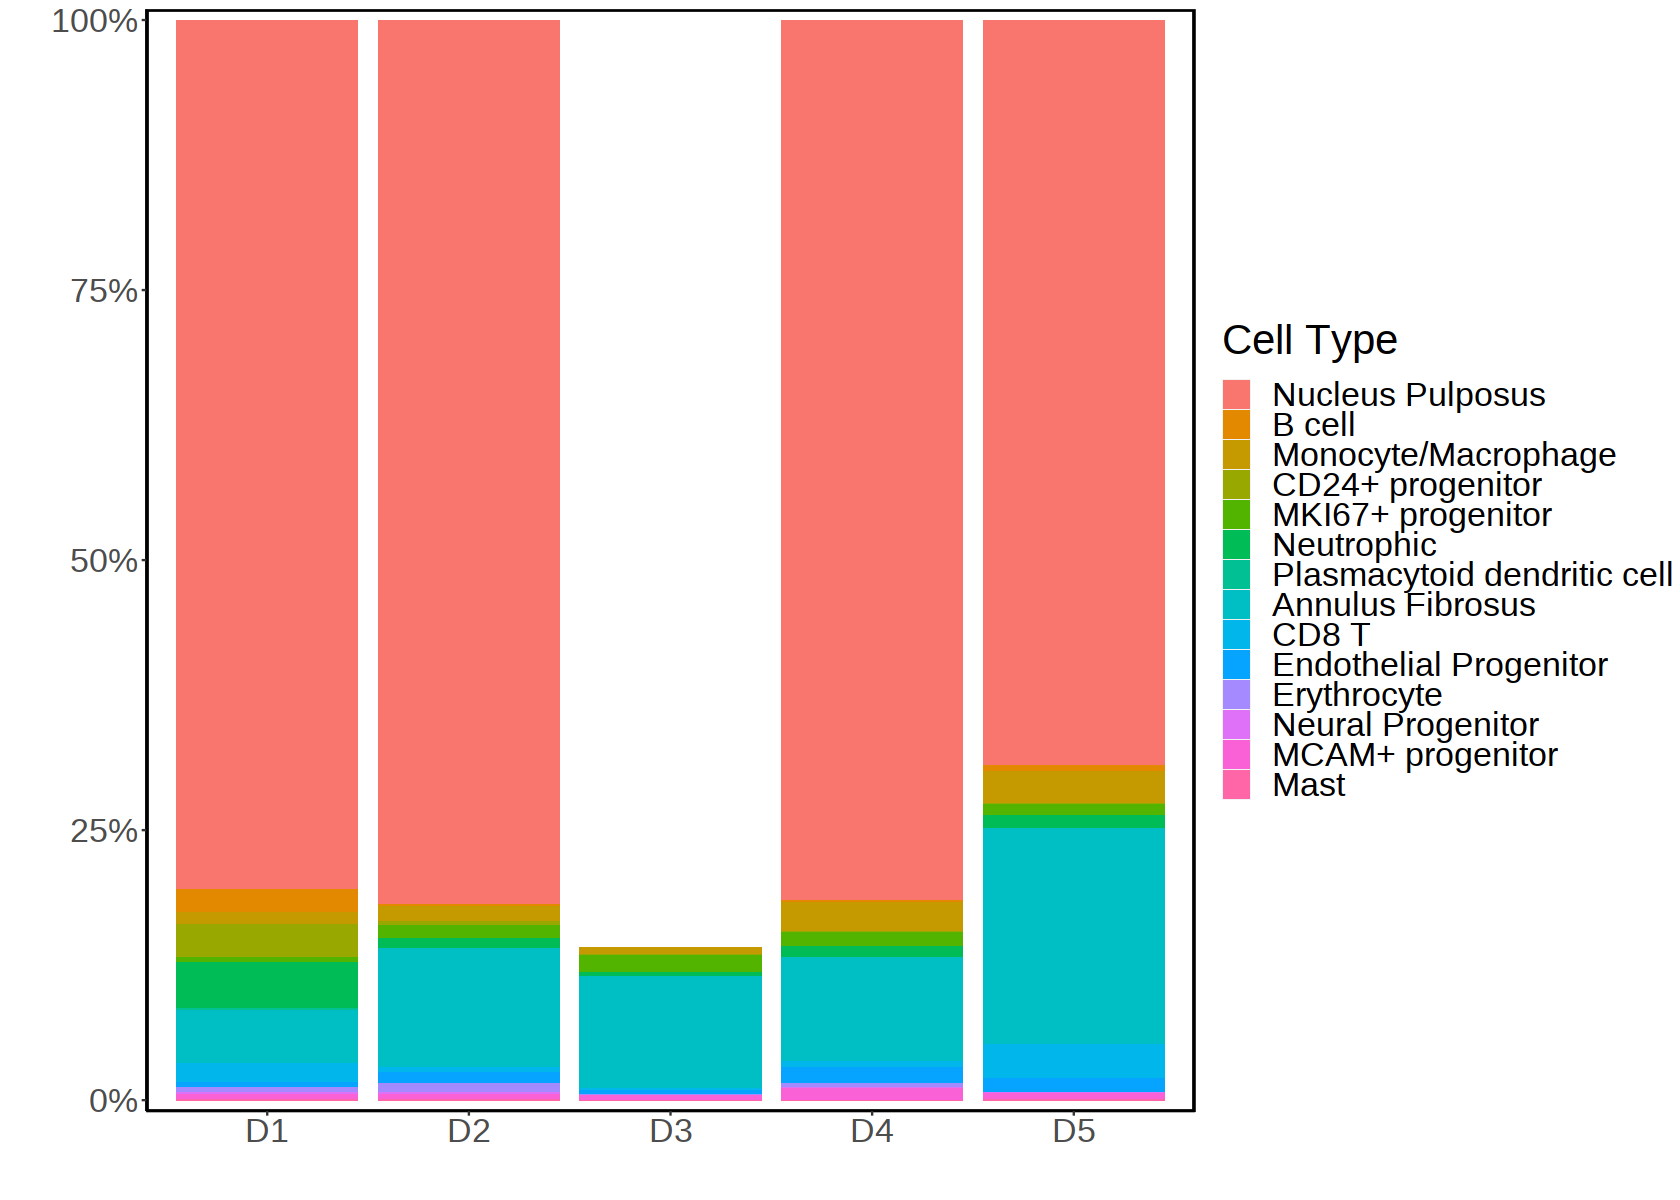

In [62]:
cell.count %>% 
    ggplot() +
    geom_bar(aes(x=grade, y=ratio, fill=celltype), stat = "identity") +
      #scale_fill_manual(values = ppe.ct.color) + 
      scale_y_continuous(limits = c(0,100), expand = c(0.01,0.01), 
                         breaks = seq(0,100, 25), labels = paste0(seq(0,100,25), "%")) +
      labs(x="", y="", fill="Cell Type") + 
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1),
            axis.line = element_line(colour = "black"),
            axis.text.x = element_text(size = 20),
            axis.text.y = element_text(size = 20),
            axis.title = element_text(size = 25),
            legend.text = element_text(size = 20),
            legend.title = element_text(size = 25))
    

In [64]:
cell.count %>% filter(grade == "D3")

grade,celltype,cellnum,ratio
<fct>,<fct>,<int>,<dbl>
D3,Nucleus Pulposus,14231,85.87894515
D3,B cell,5,0.03017319
D3,Monocyte/Macrophage,96,0.57932533
D3,CD24+ progenitor,21,0.12672742
D3,MKI67+ progenitor,266,1.60521393
D3,Neutrophic,56,0.33793977
D3,Plasmacytoid dendritic cell,0,0.00000000
D3,Annulus Fibrosus,1717,10.36147487
D3,CD8 T,23,0.13879669


In [65]:
Idents(all.seu) %>% unique()

[1] Nucleus Pulposus            B cell                     
 [3] Monocyte/Macrophage         CD24+ progenitor           
 [5] MKI67+ progenitor           Neutrophic                 
 [7] Plasmacytoid dendritic cell Annulus Fibrosus           
 [9] CD8 T                       Endothelial Progenitor     
[11] Erythrocyte                 Neural Progenitor          
[13] MCAM+ progenitor            Mast                       
14 Levels: Nucleus Pulposus B cell Monocyte/Macrophage ... Mast

# re-plot DotPlot

In [ ]:
Erythrocyte <- c("HBB", "HBA1")
MKI67_progenitor <- c("CENPF", "MKI67")
CD24_progenitor <- c("CD24", "KRT19", "CA3")
MCAM_progenitor <- c("THY1", "MCAM")
immune <- c("S100A8", "S100A9", "CD4", "CD3D", "CD38", "SRGN")
CD8_T <- c("CD8A", "NKG7", "CCL5", "SRGN")
myeloid <- c("S100A8", "S100A9", "CD74")
B_cell <- c("IGKC", "HLA-DRA", "LAPTM5")
NP <- c("ACAN", "FMOD", "COMP", "COL2A1")
AF <- c("MMP2", "COL1A1", "CRTAC1", "ASPN")
Endothelial_progenitor <- c("CD34", "PECAM1", "CDH5", "KDR")


C.plot <- 
  DotPlot(obj, features = c(NP, myeloid, MKI67_progenitor, MCAM_progenitor, Erythrocyte, Endothelial_progenitor, CD8_T, CD24_progenitor, B_cell, AF)) +
    labs(x="", y="") +
    theme(axis.text.x = element_text(angle = 60, hjust=1)) +
    theme(panel.border = element_rect(colour = "black", fill=NA, size=1))

pdf("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/plots/paper_plots/Fig1C_all_cellmarkers.pdf", width = 14)
C.plot
dev.off()

# check SPP1 Mphi global markers

In [5]:
unique(colnames(all.seu@meta.data))

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "pANN_0.25_0.19_346"                "DF.classifications_0.25_0.19_346" 
 [7] "pANN_0.25_0.21_400"                "DF.classifications_0.25_0.21_400" 
 [9] "pANN_0.25_0.3_429"                 "DF.classifications_0.25_0.3_429"  
[11] "pANN_0.25_0.005_275"               "DF.classifications_0.25_0.005_275"
[13] "pANN_0.25_0.28_510"                "DF.classifications_0.25_0.28_510" 
[15] "pANN_0.25_0.24_572"                "DF.classifications_0.25_0.24_572" 
[17] "pANN_0.25_0.3_324"                 "DF.classifications_0.25_0.3_324"  
[19] "pANN_0.25_0.3_448"                 "DF.classifications_0.25_0.3_448"  
[21] "pANN_0.25_0.005_320"               "DF.classifications_0.25_0.005_320"
[23] "pANN_0.25_0.12_653"                "DF.classifications_0.25_0.12_653" 
[25] "pANN_0.25_0.19_514"                "DF.classifications_0.25_0.19_514" 
[27] "pANN_0.25_0.3_464"                 "DF.classifications_0.25_0.3_464"  
[29] "pANN_0.25_0.005_264"               "DF.classifications_0.25_0.005_264"
[31] "pANN_0.25_0.18_512"                "DF.classifications_0.25_0.18_512" 
[33] "DF"                                "S.Score"                          
[35] "G2M.Score"                         "Phase"                            
[37] "old.ident"                         "sample_name"                      
[39] "RNA_snn_res.0.6"                   "seurat_clusters"                  
[41] "RNA_snn_res.1.5"                   "raw.celltype"                     
[43] "celltype7"                         "RNA_snn_res.1.8"                  
[45] "RNA_snn_res.2"                     "celltype2.0"                      
[47] "particular"                        "pANN_0.25_0.005_362"              
[49] "DF.classifications_0.25_0.005_362" "RNA_snn_res.2.2"                  
[51] "RNA_snn_res.2.8"                   "RNA_snn_res.3"                    
[53] "ct.raw"                            "ct.detail"                        
[55] "new.ct.raw"                        "new.ct.raw2"                      
[57] "grade.CvsS"                        "ct.raw.immune_detail"             
[59] "ct.raw.immune.gen"                 "IVD_grade2"

In [12]:
unique(Idents(all.seu))

[1] Nucleus Pulposus            B cell                     
 [3] Monocyte/Macrophage         CD24+ progenitor           
 [5] MKI67+ progenitor           Neutrophic                 
 [7] Plasmacytoid dendritic cell Annulus Fibrosus           
 [9] CD8 T                       Endothelial Progenitor     
[11] Erythrocyte                 Neural Progenitor          
[13] MCAM+ progenitor            Mast                       
14 Levels: Nucleus Pulposus B cell Monocyte/Macrophage ... Mast

In [13]:
Idents(all.seu) <- all.seu@meta.data$ct.raw.immune_detail

In [14]:
check.markers <- FindAllMarkers(all.seu, min.pct = 0.2, only.pos = TRUE, test.use="MAST")

Calculating cluster Nucleus Pulposus


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster Transitional B


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster CSTA+ Monocyte


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster CD24+ progenitor


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster MKI67+ progenitor


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster CAMP+ Ne

In [15]:
write.table(check.markers, 
        file = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/check_SPP1_Mphi_global_markers.txt",
        sep='\t', row.names=F, quote=F)

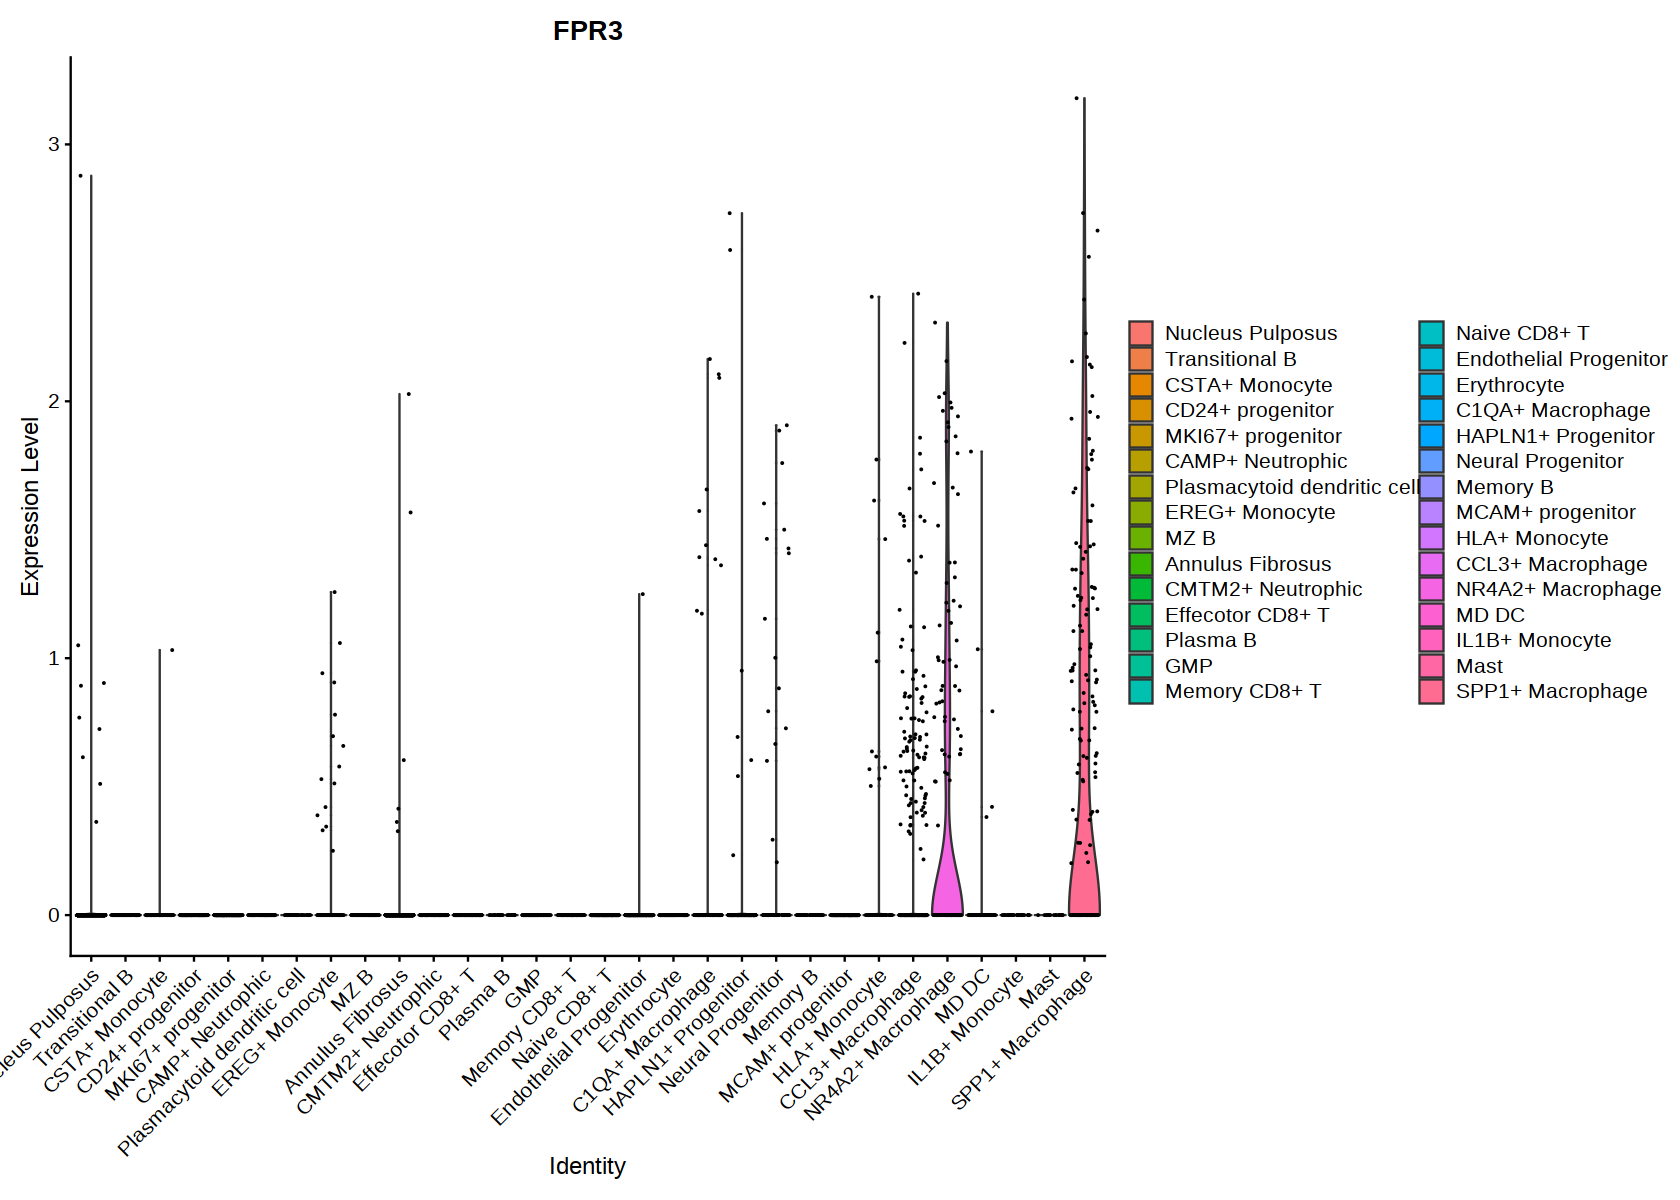

In [23]:
VlnPlot(all.seu, features = c("FPR3"))

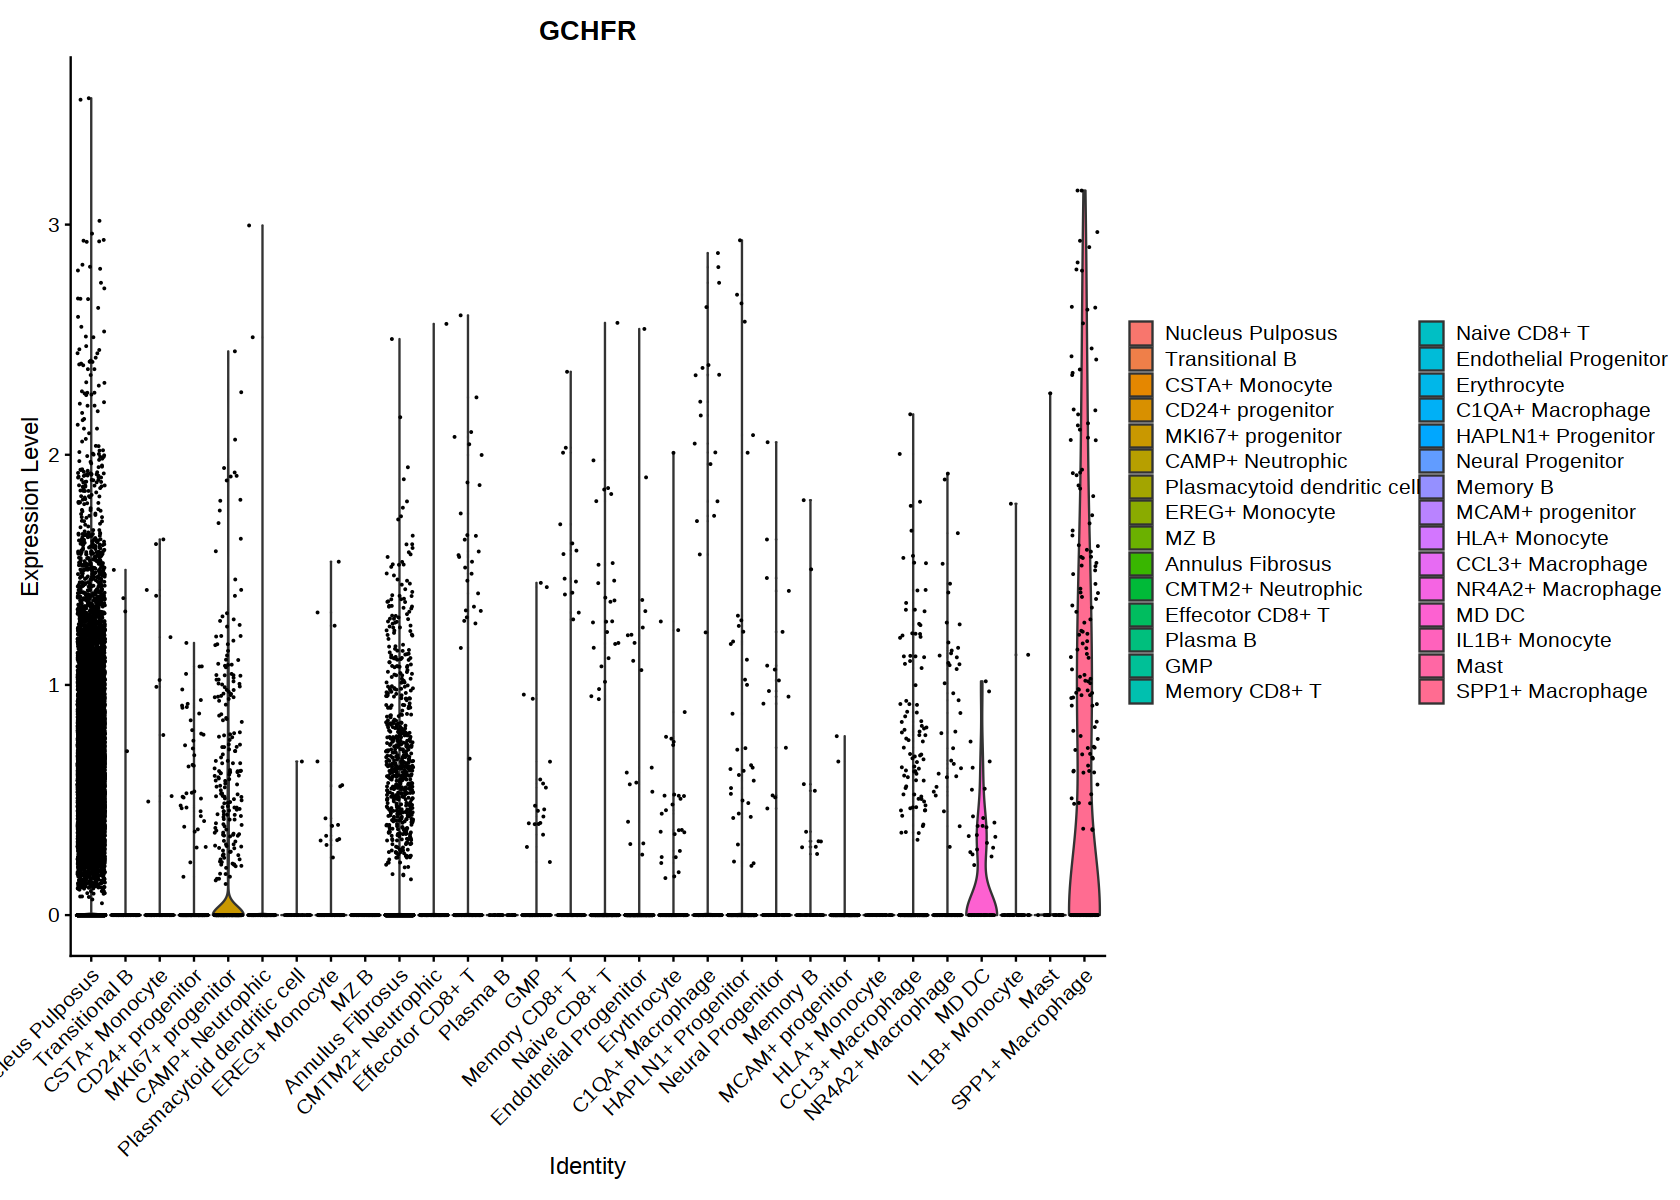

In [25]:
VlnPlot(all.seu, features = c("GCHFR"))